# Portfolio forecasting and optimization, an introduction to Financial Engineering

-   Repository: `time-series`
-   Type of Challenge: `Learning`
-   Duration: `5 days`
-   Deadline: `xx/xx/20xx 17:00` \*\*\*\*(code)\*\*\*\*
-   Presentation: `xx/xx/20xx 10:00`
-   Team challenge : 2-5

## Mission objectives

-   Understand time-series manipulations
-   Understand time-series forecasting
-   Familiarity with basic finance vocabulary
-   Experience an optimization problem
-   Deploy an app with Gradio

## The Mission

You are in the second round of an interview process with a big financial
institution. You’re past the HR interview. Congratulations! The real
process begins.

They give you a few days to create a web app in which the user can
choose a list of stocks, a time range and frequency (days, months,
years) and from these inputs calculate the **optimal portfolio** using
the most well-known technique, the **mean-variance optimization**
method. As is standard in this case, you will need to display the
**efficient-frontier** as well the **historical return, volatility,
Sharpe and Sortino ratios** for the optimal portfolio.

After a quick search, you find the well-known [Portfolio
Visualizer](https://www.portfoliovisualizer.com/) website. The
**Porfolio Optimization** section seems the most relevant. You explore
the **Historical Efficient Frontier** and the **Portfolio Optimization**
tools. Then, because you’re curious, you also check the others tools.

It is your time to impress. You think you can do better using your
Machine Learning chops. You decide to go the extra mile and not only
optimize historical portfolios at the end of the **look back** period
but to also:

-   forecast future prices over a **new** time range
-   find the optimal portfolio over the **overall (historical +
    forecasted)** time range
-   find the **actual optimal portfolio** using the actual prices on the
    **overall** time range
-   compare the 3 portfolios (return, volatility etc.) **over the new
    period**

That way, you will be able to show the efficacy of mean-variance
optimization using past data as well as the relevance of forecasting
solely based on prices. You can also reflect, as a bonus, on the merits
of your approach compared to the Black-Litterman optimization.

This should be enough to get to the next interview step in style.

## Roadmap

1.  Look-up the finance lingo.
2.  Play around with [Portfolio
    Visualizer](https://www.portfoliovisualizer.com/) keeping an eye on
    the user-experience.
3.  Explore the
    [Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/index.html)
    and in particular [Tutorial
    1](https://github.com/microprediction/Riskfolio-Lib/blob/master/examples/Tutorial%201.ipynb).
    (This [deprecated, but still fresh,
    module](https://github.com/robertmartin8/PyPortfolioOpt) could also
    be used.)
4.  Choose between [Kats](https://facebookresearch.github.io/Kats/) and
    [PyCaret](https://pycaret.org/) for regression.
5.  Deploy your app using [Gradio](https://gradio.app/).
6.  Present a 5 minutes live-demo.

## Evaluation criteria

| Criteria        | Indicator                                                | Yes/No |
|-----------------|----------------------------------------------------------|--------|
| 1\. Is complete | Your optimization works.                                 | \[ \]  |
|                 | The APP is clear and the presentation is understandable. | \[ \]  |
|                 | README is pimped.                                        | \[ \]  |
|                 | Your model is trained and can forecast prices .          | \[ \]  |
|                 | Your APP is deployed on Gradio.                          | \[ \]  |
|                 | Your MVP meets the client needs **exactly**.             | \[ \]. |
| 2\. Is good     | The repo doesn’t contain unnecessary files.              | \[ \]  |
|                 | You used typing.                                         | \[ \]  |
|                 | The presentation is clean.                               | \[ \]  |
|                 | The web-dev group understood well how your API works.    | \[ \]  |

![You’ve got
this!](attachment:vertopal_b8d1a835998d4ab7aee7ed14d7fca514/a0eb5c7a68da63b11c8573b58153e9ed6fe2ffd3.gif)

In [1]:
# import lib
%matplotlib inline
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import ARDRegression
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

try:
    import pandas_datareader.data as web
except ImportError:
    print("You need to install the pandas_datareader. Run pip install pandas_datareader.")

from sklearn.linear_model import LinearRegression


In [2]:
df = yf.download("TSLA AAPL MSFT GOOG", start="2015-01-01", end="2022-01-01",group_by="ticker")

[*********************100%***********************]  4 of 4 completed


In [3]:
def get_data(ticker):

    df = yf.download("TSLA AAPL MSFT GOOG", start="2015-01-01", end="2022-01-01",group_by="ticker")
    df = df[ticker]['Close']

    df_melted = pd.DataFrame({"Close": df.copy()})
    df_melted["date"] = df_melted.index
    df_melted["Symbols"] = ticker

    df_rolled = roll_time_series(df_melted, column_id="Symbols", column_sort="date",
                             max_timeshift=20, min_timeshift=5)
                             
    X = extract_features(df_rolled.drop("Symbols", axis=1), 
                     column_id="id", column_sort="date", column_value="Close", 
                     impute_function=impute, show_warnings=False)

    X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
    X.index.name = "last_date"
    y = df_melted.set_index("date").sort_index().Close.shift(-1)
    
    y = y[y.index.isin(X.index)]
    X = X[X.index.isin(y.index)]
    
    
    
    return X,y
    
    

    
#prepare_data("AAPL")

In [4]:
def plot_prediction(y_test,y_pred,ticker):
    plt.figure(figsize=(15, 6))
    #plt.title("Forecast for:)

    y_test.plot(ax=plt.gca())
    y_pred.plot(ax=plt.gca(),color = 'red', title = 'Forcasting price stock for '+ ticker + ' ticker')
    plt.legend(["Actual" , "Predicted"])
    plt.show()
    

In [5]:
def make_model(ticker):
    X,y = get_data(ticker)
    
    X_train = X[:"2020"]
    X_test = X["2021":]

    y_train = y[:"2020"]
    y_test = y["2021":]

    X_train_selected = select_features(X_train, y_train)
    
    #regressor = LinearRegression()
    regressor = ARDRegression()
    regressor.fit(X_train_selected, y_train)
    X_test_selected = X_test[X_train_selected.columns]
    y_pred = pd.Series(regressor.predict(X_test_selected), index=X_test_selected.index)
   
    plot_prediction(y_test,y_pred,ticker)
    return regressor, y_test, y_pred



In [6]:
def evaluate_model(y_test, y_pred):
    
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)

    print('MAE: %f' % mae)
    print('MSE: %f' % mse)
    print('RMSE: %f' % rmse)



    

[*********************100%***********************]  4 of 4 completed

c:\Users\32467\anaconda3\envs\tsfresh_env\lib\site-packages\tsfresh\utilities\dataframe_functions.py:521: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  "Your time stamps are not uniformly sampled, which makes rolling "


Feature Extraction: 100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


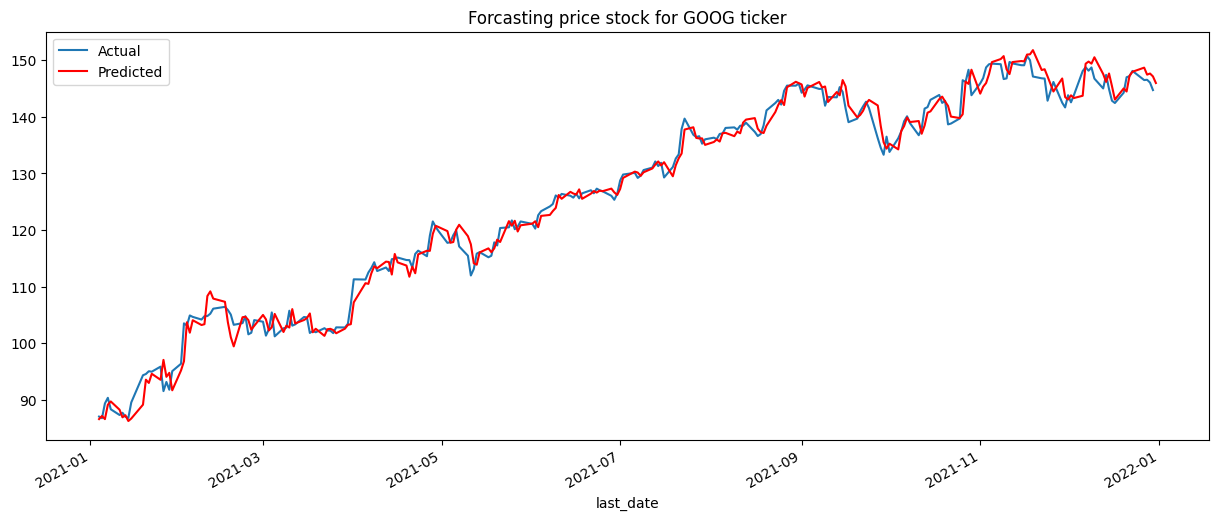

[*********************100%***********************]  4 of 4 completed

c:\Users\32467\anaconda3\envs\tsfresh_env\lib\site-packages\tsfresh\utilities\dataframe_functions.py:521: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  "Your time stamps are not uniformly sampled, which makes rolling "


Feature Extraction: 100%|██████████| 20/20 [00:48<00:00,  2.42s/it]


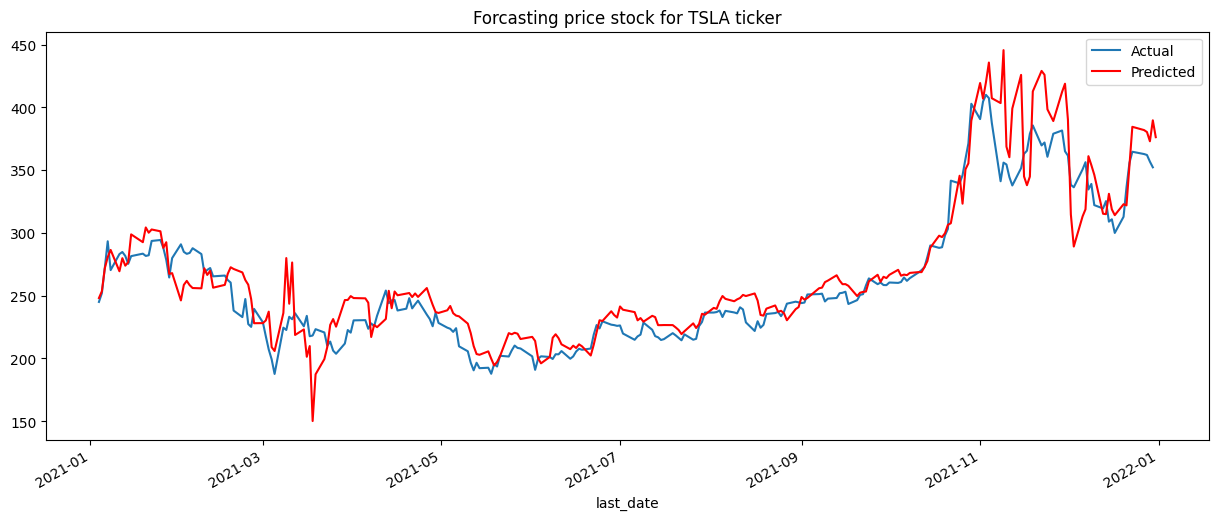

[*********************100%***********************]  4 of 4 completed

c:\Users\32467\anaconda3\envs\tsfresh_env\lib\site-packages\tsfresh\utilities\dataframe_functions.py:521: UserWarning: Your time stamps are not uniformly sampled, which makes rolling nonsensical in some domains.
  "Your time stamps are not uniformly sampled, which makes rolling "


Feature Extraction: 100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


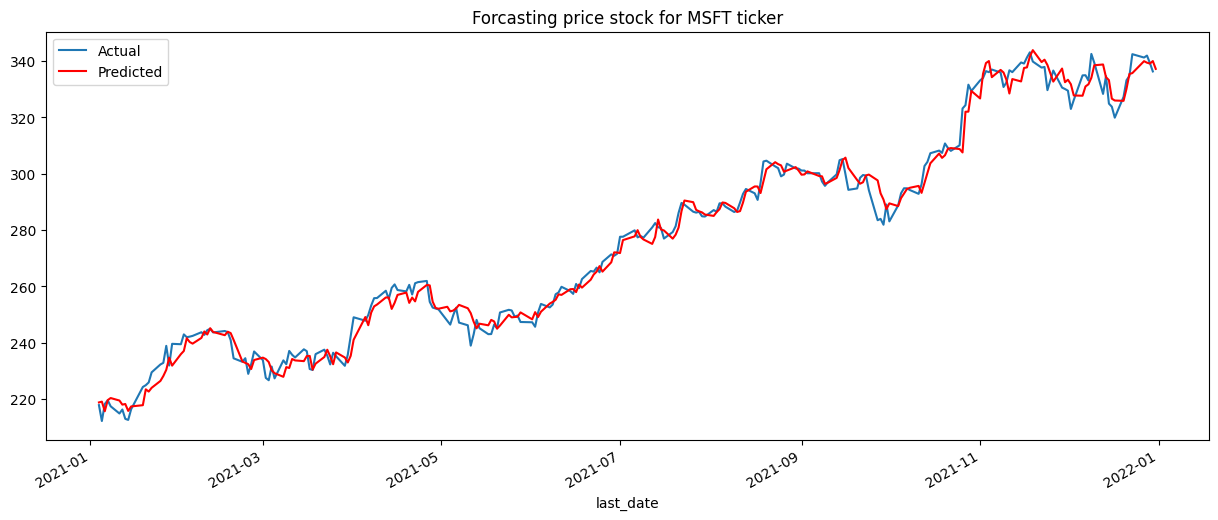

****** google_regressor ***********
MAE: 1.496444
MSE: 3.952252
RMSE: 1.988027
****** tesla_regressor ***********
MAE: 14.482482
MSE: 402.131438
RMSE: 20.053215
****** microsoft_regressor ***********
MAE: 3.057043
MSE: 16.052110
RMSE: 4.006508


In [7]:
# create forecasting models for each ticker
google_regressor, y_goog, y_p_goog = make_model("GOOG")
tesla_regressor,  y_tsla, y_p_tsla = make_model("TSLA")
microsoft_regressor, y_msft, y_p_msft = make_model("MSFT")

# evaluate the models
print("****** google_regressor ***********")
evaluate_model(y_goog[:-1], y_p_goog[:-1])
print("****** tesla_regressor ***********")
evaluate_model(y_tsla[:-1], y_p_tsla[:-1])
print("****** microsoft_regressor ***********")
evaluate_model(y_msft[:-1], y_p_msft[:-1])





In [36]:
import gradio as gr
import os

def ROI(start_date, end_date, amount, google_percentage, tsla_percentage, msft_percentage):
    amount = int(amount)
    google_percentage =int(google_percentage)
    tsla_percentage = int(tsla_percentage)
    msft_percentage = int(msft_percentage)
    

    roi_goog = round(100*(y_goog[end_date]-y_goog[start_date])/y_goog[start_date])
    roi_tsla = round(100*(y_tsla[end_date]-y_tsla[start_date])/y_tsla[start_date])
    roi_msft = round(100*(y_msft[end_date]-y_msft[start_date])/y_msft[start_date])
    
    return f""" The ROI and the profit for different tickers of initial amount {amount} euro from {start_date} to {end_date}
    The ROI for google is {roi_goog} % and the profit made is {roi_goog*google_percentage/100}
    The ROI for google is {roi_tsla} % and the profit made is {roi_tsla*tsla_percentage/100}
    The ROI for google is {roi_msft} % and the profit made is {roi_msft*google_percentage/100}
    """


with gr.Blocks() as demo:
    
    txt_0= gr.Textbox(label="start_date")
    txt_1= gr.Textbox(label="end_date")
    txt_2= gr.Textbox(label="Amount")
    txt_3= gr.Textbox(label="Google %")
    txt_4= gr.Textbox(label="Tesla %")
    txt_5= gr.Textbox(label="microsoft")
    txt_6= gr.TextArea(value="", label="Output")
    btn = gr.Button(value="Submit")
    btn.click(ROI, inputs=[txt_0,txt_1,txt_2,txt_3,txt_4,txt_5], outputs=[txt_6])
    

if __name__ == "__main__":
    demo.launch()

Running on local URL:  http://127.0.0.1:7879

To create a public link, set `share=True` in `launch()`.
